# Testing PID controller

This notebook shows how to test and tune PID controller. 


* The PID controller has to be implemented in [pid.py](./pid.py) first;
* Make sure ipywidgets is enabled with command: 
    ```sh
    jupyter nbextension enable --py widgetsnbextension
    ```
    read more in [ipywidgets wiki](https://github.com/jupyter-widgets/ipywidgets/blob/master/README.md#install)

In [3]:
%matplotlib notebook
from matplotlib import pylab as plt
from ipywidgets import interact
from IPython import display
from collections import deque

## start simspark
Start SimSpark simulator as described in [last lecture](../introduction/README.md)

## run PIDAgent
Run all code below, there is plot show current joint angle and desired joint angle.

You can set target value and tune the PID parameters to get better results. 


In [4]:
from pid import PIDAgent
agent = PIDAgent()

In [5]:
@interact(delay=(0, 5))
def set_pid_parameters(delay=0):
    global agent
    agent.joint_controller.set_delay(delay)

    
agent.joint_controller.Kp = 20
agent.joint_controller.Ki = 1
agent.joint_controller.Kd = -0.1

joint_name = 'HeadYaw'
sensor = deque(maxlen=100)
target = deque(maxlen=100)

@interact(name=agent.joint_names)
def set_joint_name(name):
    global joint_name
    if joint_name != name:
        joint_name = name
        sensor.clear()
        target.clear()

agent.target_joints[joint_name] = 0.7

interactive(children=(IntSlider(value=0, description='delay', max=5), Output()), _dom_classes=('widget-interac…

interactive(children=(Dropdown(description='name', options=('HeadYaw', 'HeadPitch', 'LShoulderPitch', 'LShould…

<IPython.core.display.Javascript object>


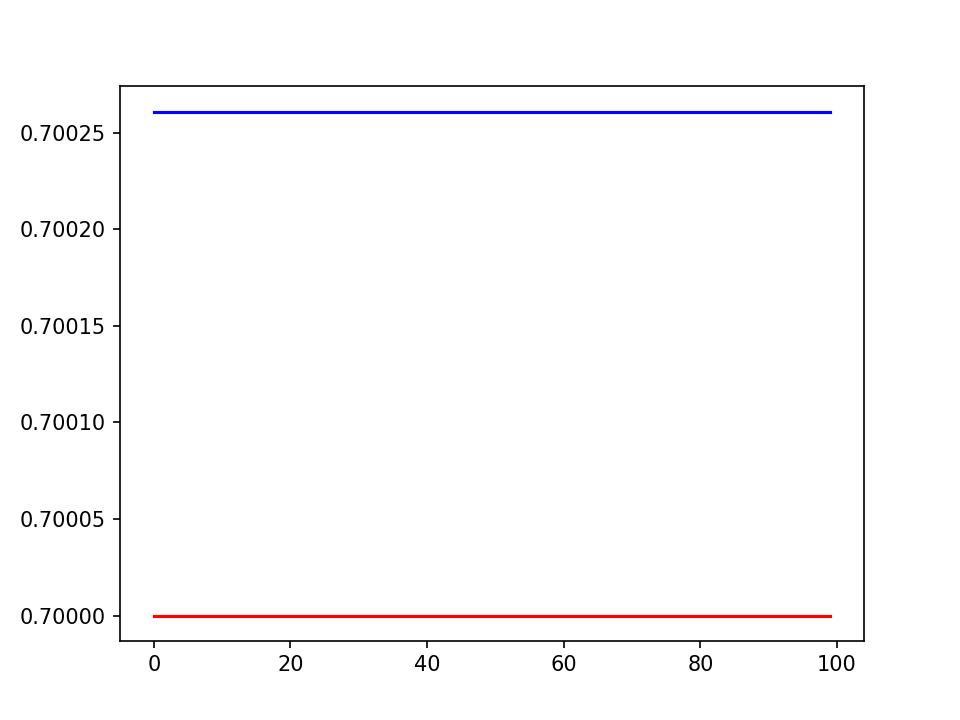

In [6]:
# inject plotting input agent's loop
cycle = 0
orig_sense_think_act = agent.sense_think_act
def sense_think_act():
    global cycle
    cycle += 1
    orig_sense_think_act()
    sensor.append(agent.perception.joint[joint_name])
    target.append(agent.target_joints[joint_name])
    if cycle % 10 == 0:  # plot every 10 cycles
        plt.cla()
        plt.plot(target, '-r')
        plt.plot(sensor, '-b')
        plt.show()
        #display.clear_output(wait=True)
        #display.display(gcf())
agent.sense_think_act = sense_think_act
agent.start()